In [ ]:
#data preprocessing

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

# Load the dataset
file_path = "dermatology_database_1.csv"
df = pd.read_csv(file_path)

# Display basic dataset info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Handle missing values (fill with mean for numerical columns)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Encode categorical variables if any
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders

# Remove ID column if present (assuming first column is an index or ID)
df = df.iloc[:, 1:]

# Separate features and target
X = df.iloc[:, :-1]  # All columns except the last one
y = df.iloc[:, -1]   # Target column

# Outlier Detection using Z-score method
z_scores = np.abs(stats.zscore(X))
threshold = 3
mask = (z_scores < threshold).all(axis=1)

# Filter out the outliers
X = X[mask]
y = y[mask]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("\nPreprocessing Completed!")
print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   erythema                             366 non-null    int64 
 1   scaling                              366 non-null    int64 
 2   definite_borders                     366 non-null    int64 
 3   itching                              366 non-null    int64 
 4   koebner_phenomenon                   366 non-null    int64 
 5   polygonal_papules                    366 non-null    int64 
 6   follicular_papules                   366 non-null    int64 
 7   oral_mucosal_involvement             366 non-null    int64 
 8   knee_and_elbow_involvement           366 non-null    int64 
 9   scalp_involvement                    366 non-null    int64 
 10  family_history                       366 non-null    int64 
 11  melanin_incontinence           

In [5]:
#top 10 features

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("dermatology_database_1.csv")

# Print shape
print("Number of records (rows):", df.shape[0])
print("Number of attributes (columns):", df.shape[1])

Number of records (rows): 366
Number of attributes (columns): 35


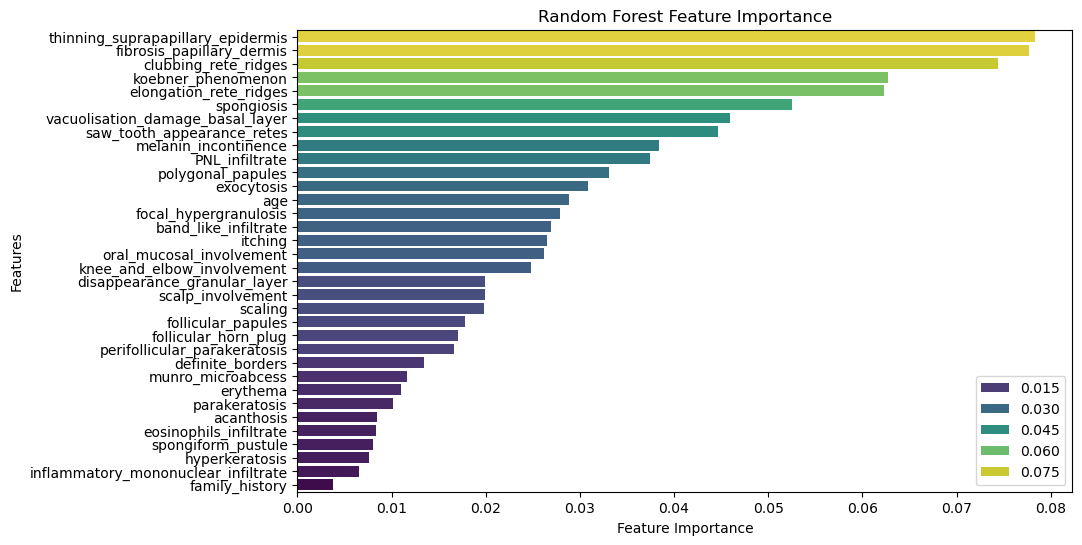

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv('Downloads/dermatology_database_1.csv')

# Splitting dataset
X = df.iloc[:, :-1]  # Features (all columns except the last)
y = df.iloc[:, -1]   # Target (last column)

# Handling non-numeric values
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
X.fillna(X.mean(), inplace=True)
y.fillna(y.mode()[0], inplace=True)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing features
scaler = StandardScaler()

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Classification Report
#print("Random Forest Classification Report:")
#print(classification_report(y_test, y_pred))

# Feature Importance Calculation
importance = np.abs(rf_model.feature_importances_)

# Sort feature importance
sorted_idx = np.argsort(importance)[::-1]

# Convert X.columns to a numpy array to prevent indexing issues
feature_names = np.array(X.columns)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=importance[sorted_idx], y=feature_names[sorted_idx], hue=importance[sorted_idx], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()

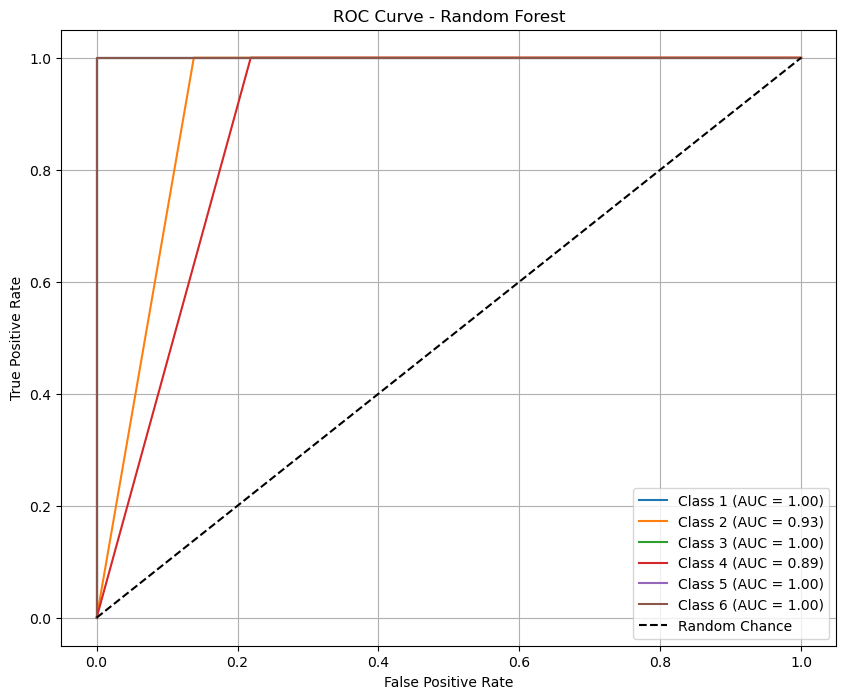

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# Load dataset
df = pd.read_csv('dermatology_database_1.csv')

# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Convert all columns to numeric (non-convertible '?' becomes NaN)
df = df.apply(pd.to_numeric, errors='coerce')

# Drop rows with any missing values
df.dropna(inplace=True)

# Separate features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Feature selection (top 10 features)
X_selected = SelectKBest(score_func=f_classif, k=10).fit_transform(X, y)

# Binarize the labels for multi-class ROC
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Split data into training and testing sets
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X_selected, y_bin, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train_bin)

# Predict class probabilities
y_score = rf.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[i][:, 1] if isinstance(y_score, list) else y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()

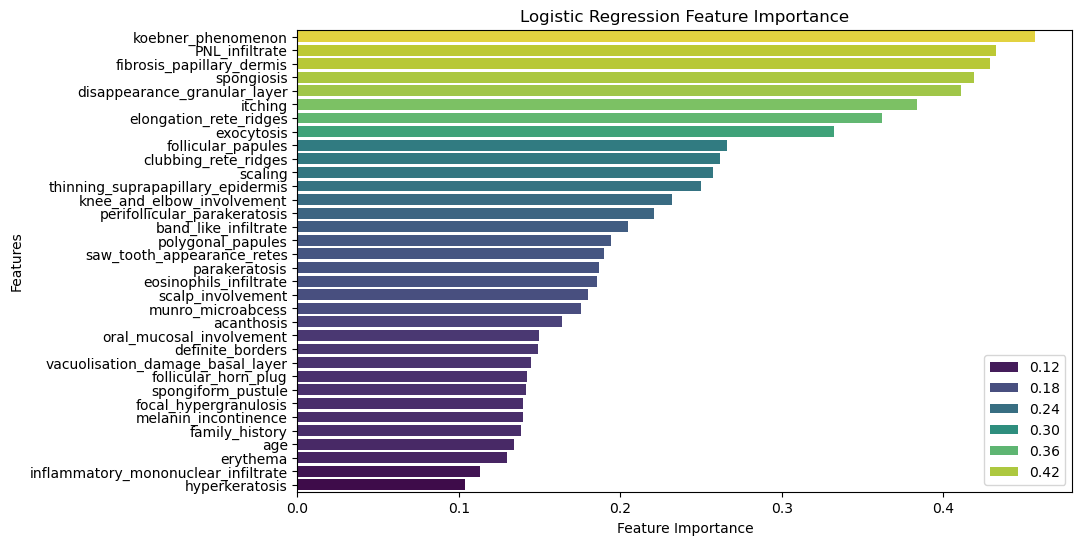

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv('Downloads/dermatology_database_1.csv')

# Splitting dataset
X = df.iloc[:, :-1]  
y = df.iloc[:, -1]   

# Handling non-numeric values
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
X.fillna(X.mean(), inplace=True)
y.fillna(y.mode()[0], inplace=True)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Classification Report
#print("Logistic Regression Classification Report:")
#print(classification_report(y_test, y_pred))

# Feature Importance Handling
importance = np.abs(log_reg.coef_).mean(axis=0)  

# Visualization
sorted_idx = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importance[sorted_idx], y=feature_names[sorted_idx], hue=importance[sorted_idx], palette="viridis")


plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance")
plt.show()

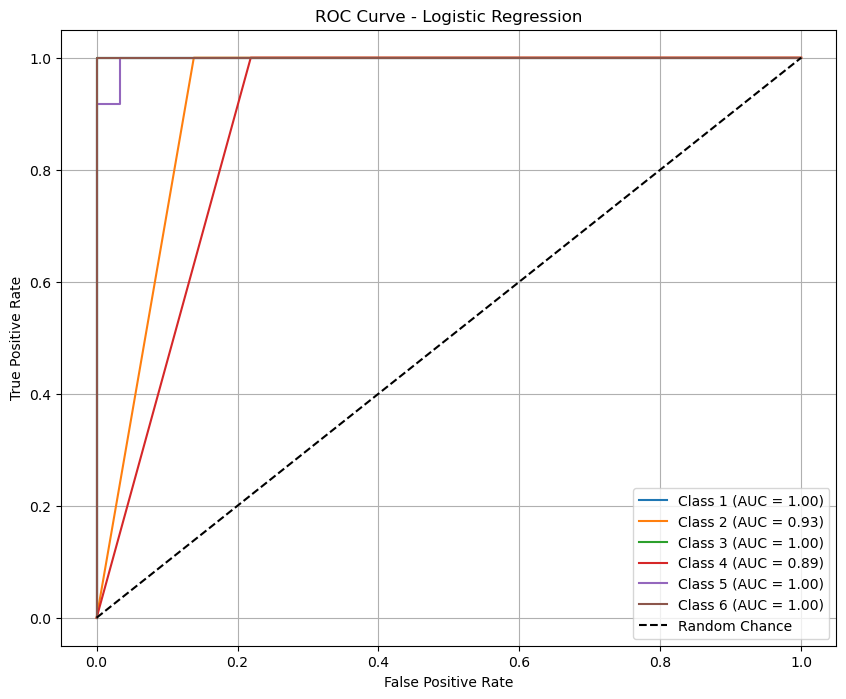

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif

# Load and preprocess data
df = pd.read_csv('dermatology_database_1.csv')
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# Features and labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Feature selection
X_selected = SelectKBest(score_func=f_classif, k=10).fit_transform(X, y)

# Binarize y for ROC (but keep original y for training)
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Logistic Regression
model = LogisticRegression( solver='liblinear')
model.fit(X_train, y_train)  # y_train is 1D here

# Get scores
y_score = model.decision_function(X_test)

# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

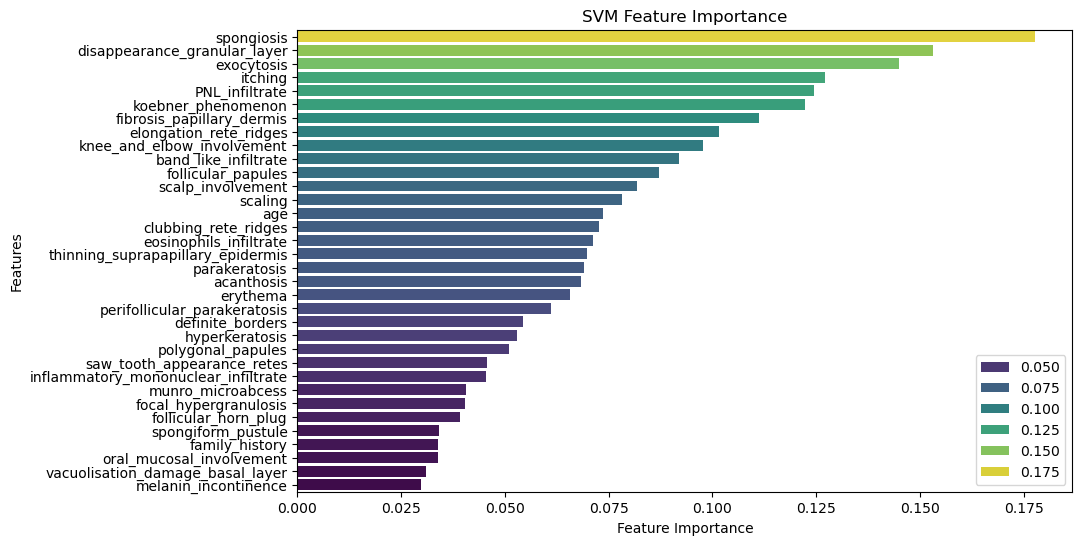

In [11]:
from sklearn.svm import SVC

# SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Classification Report
#print("SVM Classification Report:")
#print(classification_report(y_test, y_pred))

# Feature Importance Handling
importance = np.abs(svm_model.coef_).mean(axis=0)  

# Visualization
sorted_idx = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importance[sorted_idx], y=feature_names[sorted_idx], hue=importance[sorted_idx], palette="viridis")


plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("SVM Feature Importance")
plt.show()

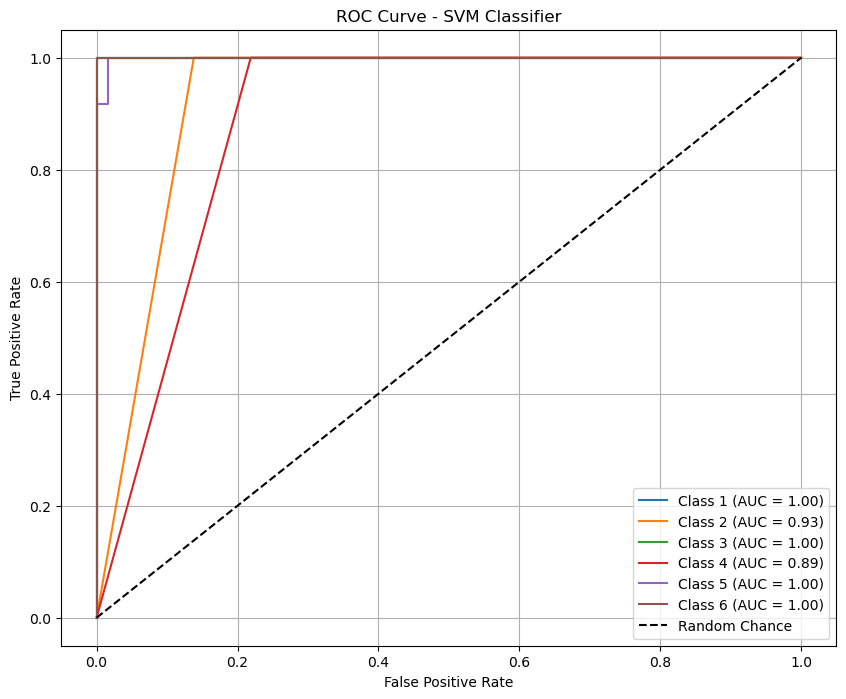

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif

# Load and preprocess data
df = pd.read_csv('dermatology_database_1.csv')
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# Feature matrix and target vector
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Feature selection
X_selected = SelectKBest(score_func=f_classif, k=10).fit_transform(X, y)

# Binarize target for ROC
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM Classifier with probability=True
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Predict probabilities
y_score = svm.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Classifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()


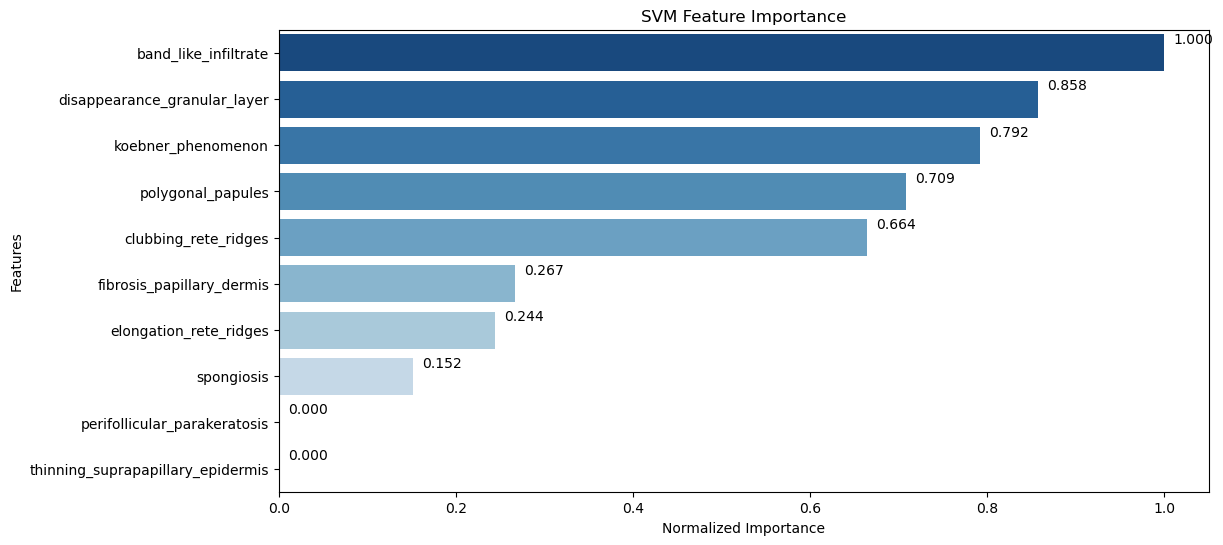

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# --------------------- Load Dataset ---------------------
file_path = "Downloads/dermatology_database_1.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Handle missing values (Fill numeric columns with mean)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Encode categorical variables if any
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Separate features and target
X = df.iloc[:, :-1]  # Features (all columns except last)
y = df.iloc[:, -1]   # Target (last column)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --------------------- Train SVM Classifier with RFE ---------------------
svm = SVC(kernel='linear')  # Linear kernel for feature importance
rfe = RFE(svm, n_features_to_select=10)  # Select top 10 features
rfe.fit(X_train, y_train)

# Ensure correct indexing of selected features
selected_feature_indices = np.where(rfe.support_)[0]  # Indices of selected features
selected_features = X.columns[selected_feature_indices]  # Feature names

# Get absolute coefficients of selected features
feature_importance = np.abs(rfe.estimator_.coef_).flatten()

# Normalize importance values to make small ones visible
feature_importance_selected = feature_importance[selected_feature_indices]
feature_importance_selected = feature_importance_selected / feature_importance_selected.max()  # Normalize

# --------------------- Create DataFrame for Plot ---------------------
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importance_selected
}).sort_values(by='Importance', ascending=False)

# --------------------- Plot Feature Importance ---------------------
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=feature_importance_df['Importance'], 
                 y=feature_importance_df['Feature'], 
                 hue=feature_importance_df['Feature'],  # Assign hue
                 palette='Blues_r', 
                 legend=False)  # Disable legend

plt.xlabel("Normalized Importance")
plt.ylabel("Features")
plt.title("SVM Feature Importance")

# Add value labels to bars
for i in ax.patches:
    ax.annotate(f"{i.get_width():.3f}",  
                (i.get_width() + 0.01, i.get_y() + 0.2),  # Adjust text position
                fontsize=10, 
                color='black')

plt.show()


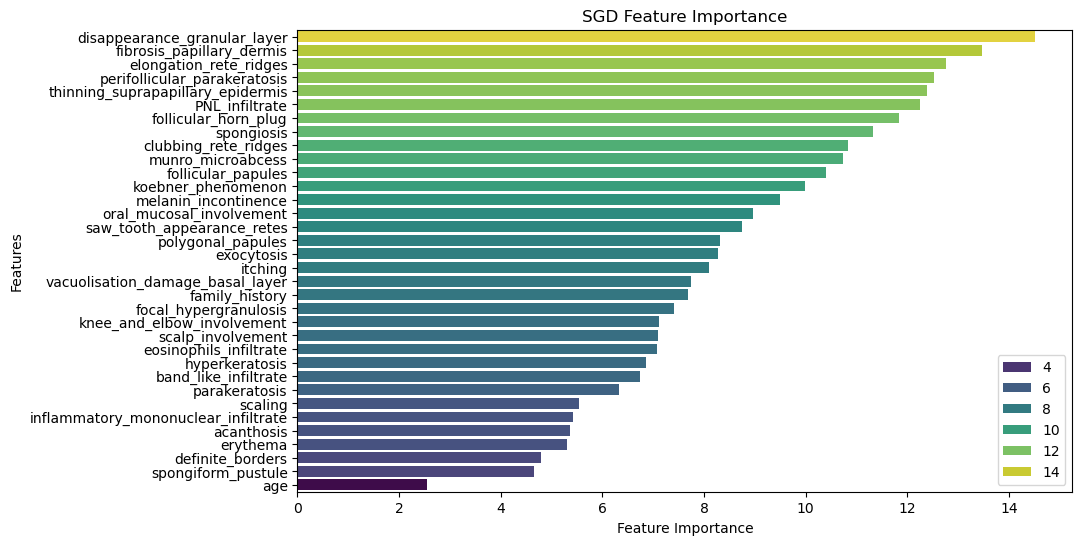

In [17]:
from sklearn.linear_model import SGDClassifier

# SGD model
sgd_model = SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3)
sgd_model.fit(X_train, y_train)

# Predictions
y_pred = sgd_model.predict(X_test)

# Classification Report
#print("SGD Classification Report:")
#print(classification_report(y_test, y_pred))

# Feature Importance Handling
importance = np.abs(sgd_model.coef_).mean(axis=0)  
#feature_names = np.array(X.columns)


# Visualization
sorted_idx = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importance[sorted_idx], y=feature_names[sorted_idx], hue=importance[sorted_idx], palette="viridis")


plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("SGD Feature Importance")
plt.show()

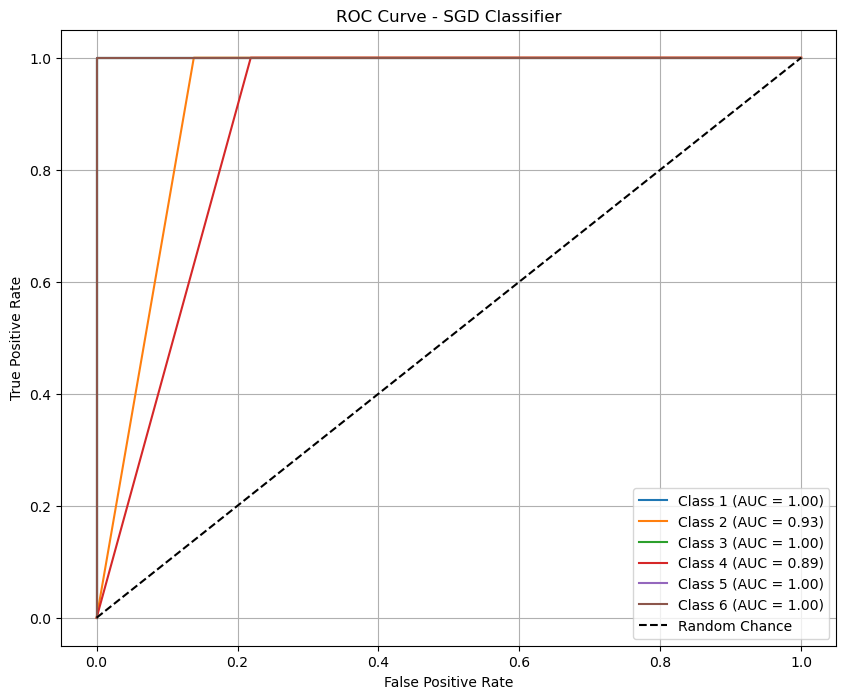

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif

# Load and preprocess data
df = pd.read_csv('dermatology_database_1.csv')
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# Features and labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Feature selection
X_selected = SelectKBest(score_func=f_classif, k=10).fit_transform(X, y)

# Binarize y for ROC (only for evaluation, not model training)
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SGD Classifier (One-vs-Rest strategy)
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(X_train, y_train)  # y_train is 1D

# Get decision function scores for ROC
y_score = sgd.decision_function(X_test)

# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SGD Classifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()

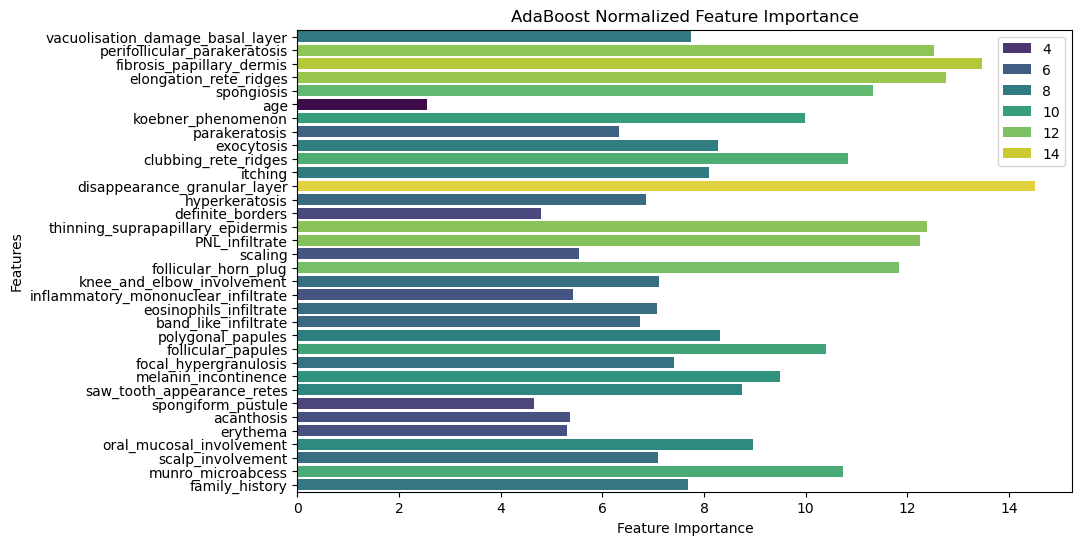

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the dataset
df = pd.read_csv("Downloads/dermatology_database_1.csv")  # Ensure correct path

# Convert non-numeric values
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode target if necessary
if df.iloc[:, -1].dtype == object:
    label_encoder = LabelEncoder()
    df.iloc[:, -1] = label_encoder.fit_transform(df.iloc[:, -1])

# Separate features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize AdaBoost with correct parameter name
base_clf = DecisionTreeClassifier(max_depth=3, class_weight="balanced")
ada_model = AdaBoostClassifier(estimator=base_clf, n_estimators=100, random_state=42)  # Fixed estimator

# Train the model
ada_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = ada_model.predict(X_test_scaled)
#print("Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))

# Feature Importance Plot
feature_importances = ada_model.feature_importances_
normalized_importance = feature_importances / np.sum(feature_importances)

# Sort and plot
sorted_idx = np.argsort(normalized_importance)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importance[sorted_idx], y=feature_names[sorted_idx], hue=importance[sorted_idx], palette="viridis")


plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("AdaBoost Normalized Feature Importance")
plt.show()

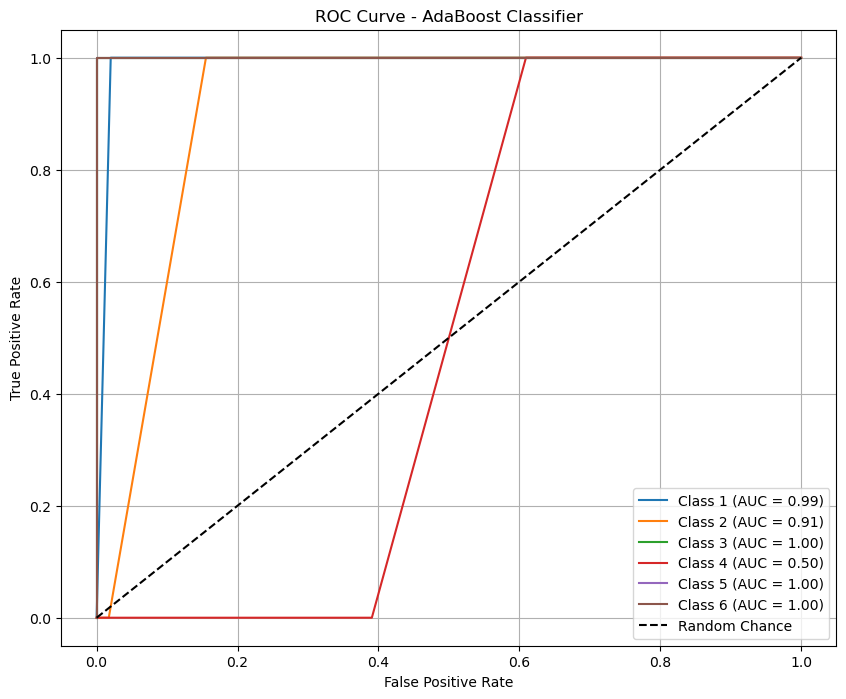

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif

# Load and preprocess data
df = pd.read_csv('dermatology_database_1.csv')
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# Feature matrix and target vector
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Feature selection
X_selected = SelectKBest(score_func=f_classif, k=10).fit_transform(X, y)

# Binarize target for ROC
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train AdaBoost Classifier
adb = AdaBoostClassifier(n_estimators=100, random_state=42)
adb.fit(X_train, y_train)

# Predict probabilities
y_score = adb.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AdaBoost Classifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from scipy import stats


# Load dataset
file_path = "Downloads/dermatology_database_1.csv"
df = pd.read_csv(file_path)

# Handle missing values (Fill numeric columns with mean)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Encode categorical variables if any
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Separate features and target
X = df.iloc[:, :-1]  # Features (all columns except last)
y = df.iloc[:, -1]   # Target (last column)

z_scores = np.abs(stats.zscore(X))
threshold = 3
mask = (z_scores < threshold).all(axis=1)

# Filter out the outliers
X = X[mask]
y = y[mask]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Scale features
##scaler = StandardScaler()
##X_scaled = scaler.fit_transform(X)

# Split dataset (80% training, 20% testing)
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --------------------- Train & Evaluate Models ---------------------
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "SGD": SGDClassifier(max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42)
}

# Train, Predict & Evaluate Each Model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Model Evaluation:")
    print(classification_report(y_test, y_pred, zero_division=1))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")



Training Random Forest...

Random Forest Model Evaluation:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       0.86      0.75      0.80         8
           3       1.00      1.00      1.00        13
           4       0.78      0.88      0.82         8
           5       1.00      1.00      1.00         5

    accuracy                           0.94        52
   macro avg       0.93      0.93      0.92        52
weighted avg       0.94      0.94      0.94        52

Accuracy: 0.9423

Training Logistic Regression...

Logistic Regression Model Evaluation:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        18
           2       1.00      0.62      0.77         8
           3       1.00      1.00      1.00        13
           4       0.73      1.00      0.84         8
           5       1.00      1.00      1.00         5

    accuracy                        

In [ ]:
#random forest classifier feature Selection

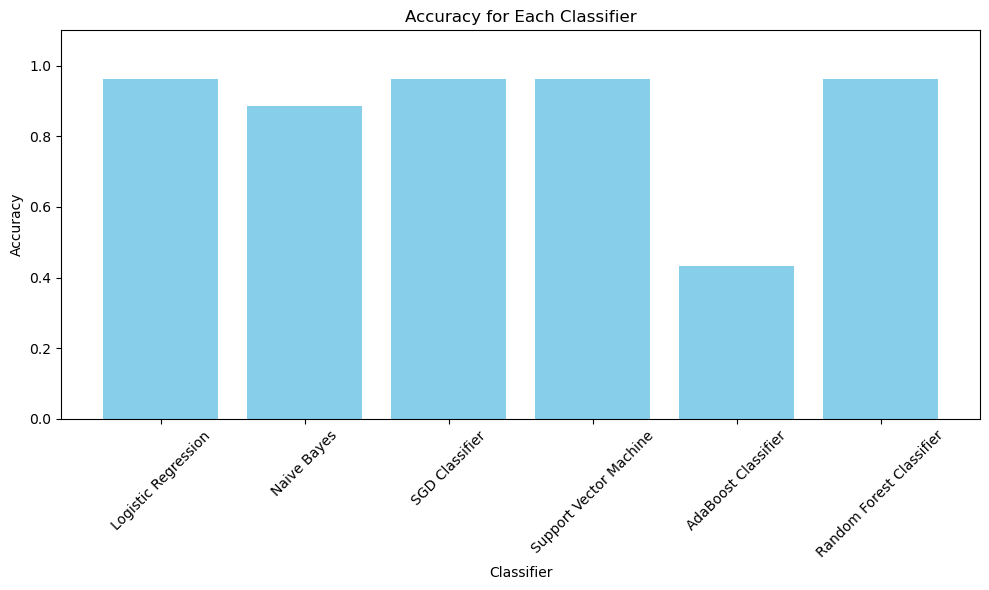

In [10]:

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Split the dataset
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize classifiers
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'SGD Classifier': SGDClassifier(random_state=42),
    'Support Vector Machine': SVC(kernel='linear', random_state=42),
    'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Store accuracies
accuracies = {}

# Train, predict, and evaluate each classifier
for name, model in models.items():
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc

# Plotting bar chart
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.xlabel('Classifier')
plt.title('Accuracy for Each Classifier')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

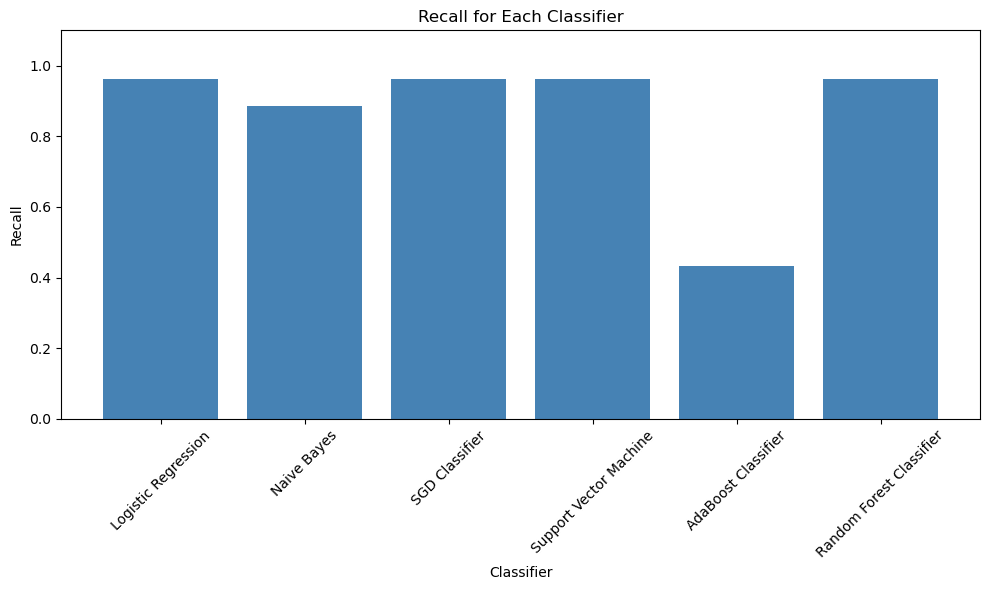

In [12]:
import pandas as pd
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

# Load dataset
#data = pd.read_csv('dermatology_database_1.csv')

# Separate features and target
#X = data.iloc[:, :-1]  # All columns except the last one
#y = data.iloc[:, -1]   # The last column

# Feature scaling
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'SGD Classifier': SGDClassifier(),
    'Support Vector Machine': SVC(kernel='linear'),
    'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100)
}

# Train, predict, and compute recall for each classifier
recalls = {}
for name, model in models.items():
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    recalls[name] = recall_score(y_test, y_pred, average='weighted', zero_division=0)

# Plot Recall scores
plt.figure(figsize=(10, 6))
plt.bar(recalls.keys(), recalls.values(), color='steelblue')
plt.ylabel('Recall')
plt.xlabel('Classifier')
plt.title('Recall for Each Classifier')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

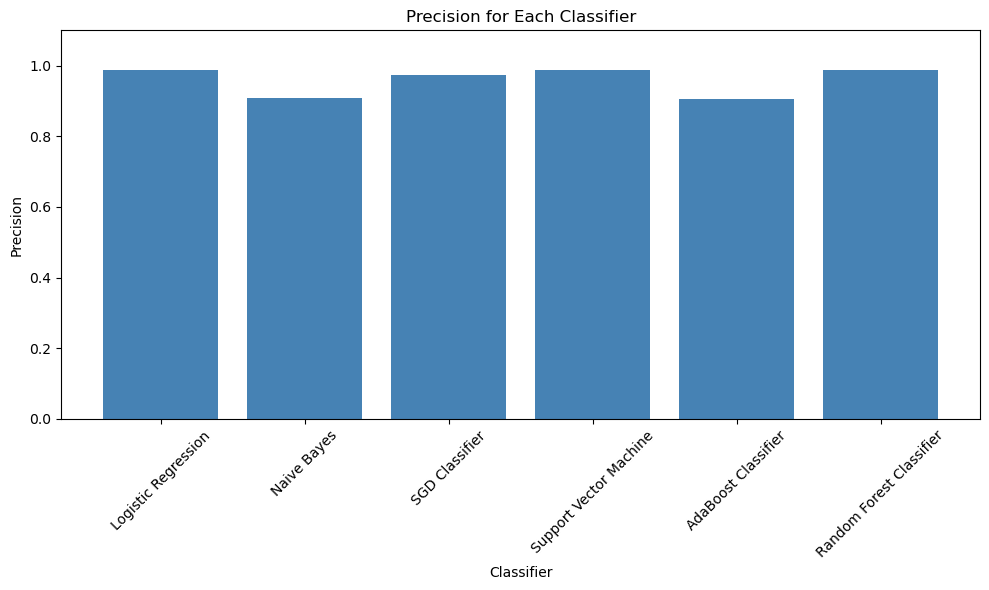

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

# Load dataset
#data = pd.read_csv('dermatology_database_1.csv')  # Use your actual CSV file

# Separate features and target
#X = data.drop('target_column_name', axis=1)  # Replace with actual target column name
#y = data['target_column_name']

# Feature scaling
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Train-test split
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'SGD Classifier': SGDClassifier(),
    'Support Vector Machine': SVC(kernel='linear'),
    'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100)
}

# Train, predict and calculate precision
precisions = {}
for name, model in models.items():
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    precisions[name] = precision_score(y_test, y_pred, average='weighted', zero_division=0)

# Plot precision scores
plt.figure(figsize=(10, 6))
plt.bar(precisions.keys(), precisions.values(), color='steelblue')
plt.ylabel('Precision')
plt.xlabel('Classifier')
plt.title('Precision for Each Classifier')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

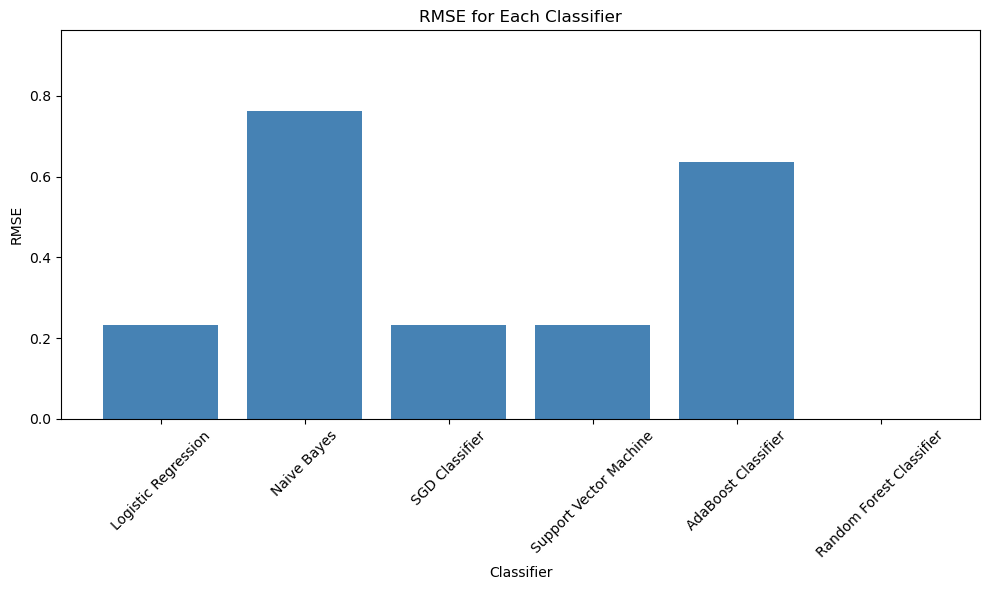

In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Split dataset (use your preprocessed features and labels here)
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'SGD Classifier': SGDClassifier(),
    'Support Vector Machine': SVC(kernel='linear'),
    'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100)
}

# Calculate RMSE for each model
rmse_scores = {}
for name, model in models.items():
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores[name] = rmse

# Plot RMSE bar chart
plt.figure(figsize=(10, 6))
plt.bar(rmse_scores.keys(), rmse_scores.values(), color='steelblue')
plt.title('RMSE for Each Classifier')
plt.xlabel('Classifier')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.ylim(0, max(rmse_scores.values()) + 0.2)
plt.tight_layout()
plt.show()

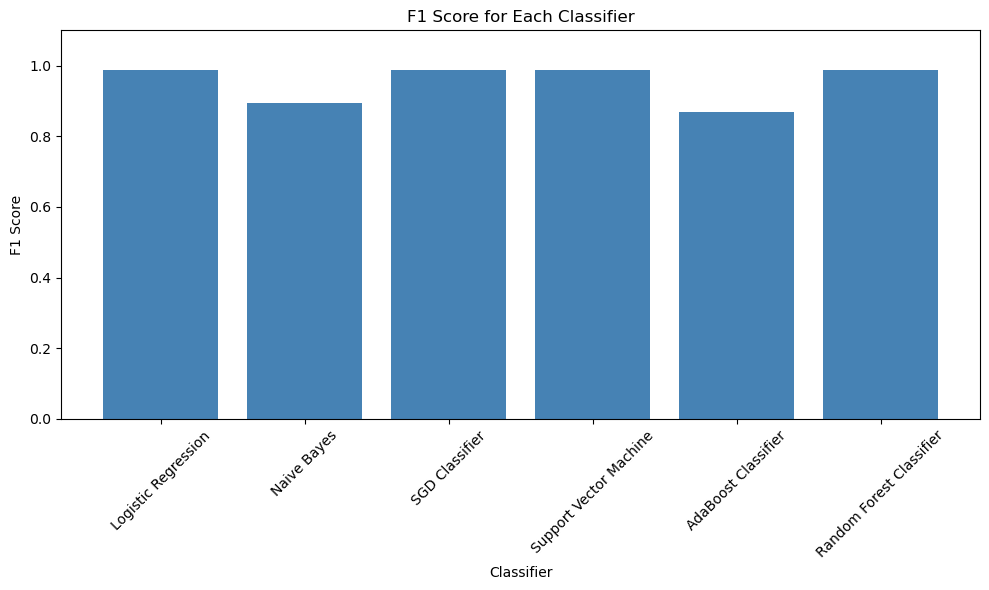

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Load dataset
#data = pd.read_csv('dermatology_database_1.csv')

# Separate features and target
#X = data.iloc[:, :-1]  # All columns except the last one
#y = data.iloc[:, -1]   # The last column

# Feature scaling
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'SGD Classifier': SGDClassifier(),
    'Support Vector Machine': SVC(kernel='linear'),
    'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100)
}

# Train, predict, and compute F1 score for each classifier
f1_scores = {}
for name, model in models.items():
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    f1_scores[name] = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Plot F1 scores
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values(), color='steelblue')
plt.ylabel('F1 Score')
plt.xlabel('Classifier')
plt.title('F1 Score for Each Classifier')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

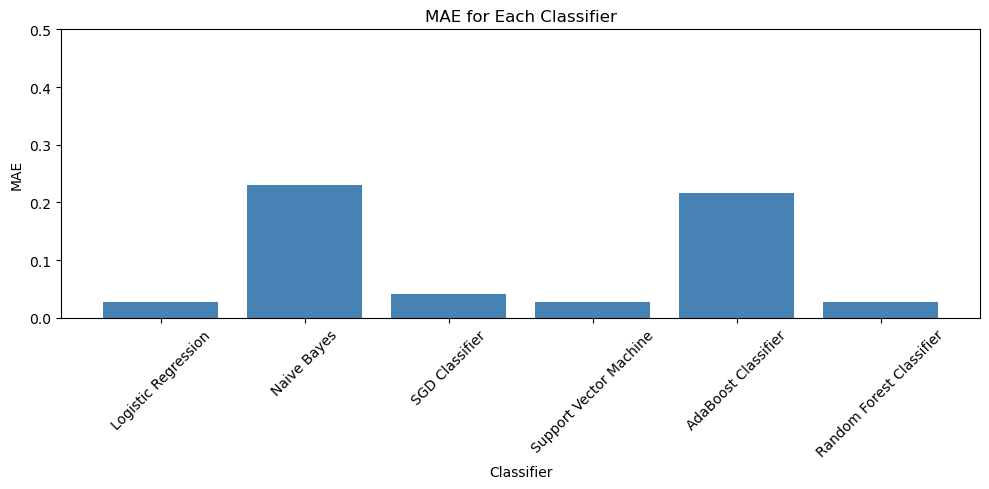

In [9]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt

# Split your dataset
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'SGD Classifier': SGDClassifier(),
    'Support Vector Machine': SVC(kernel='linear'),
    'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100)
}

# Calculate MAE for each model
mae_scores = {}
for name, model in models.items():
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    mae_scores[name] = mean_absolute_error(y_test, y_pred)

# Plot the MAE bar chart
plt.figure(figsize=(10, 5))
plt.bar(mae_scores.keys(), mae_scores.values(), color='steelblue')
plt.title('MAE for Each Classifier')
plt.xlabel('Classifier')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.show()

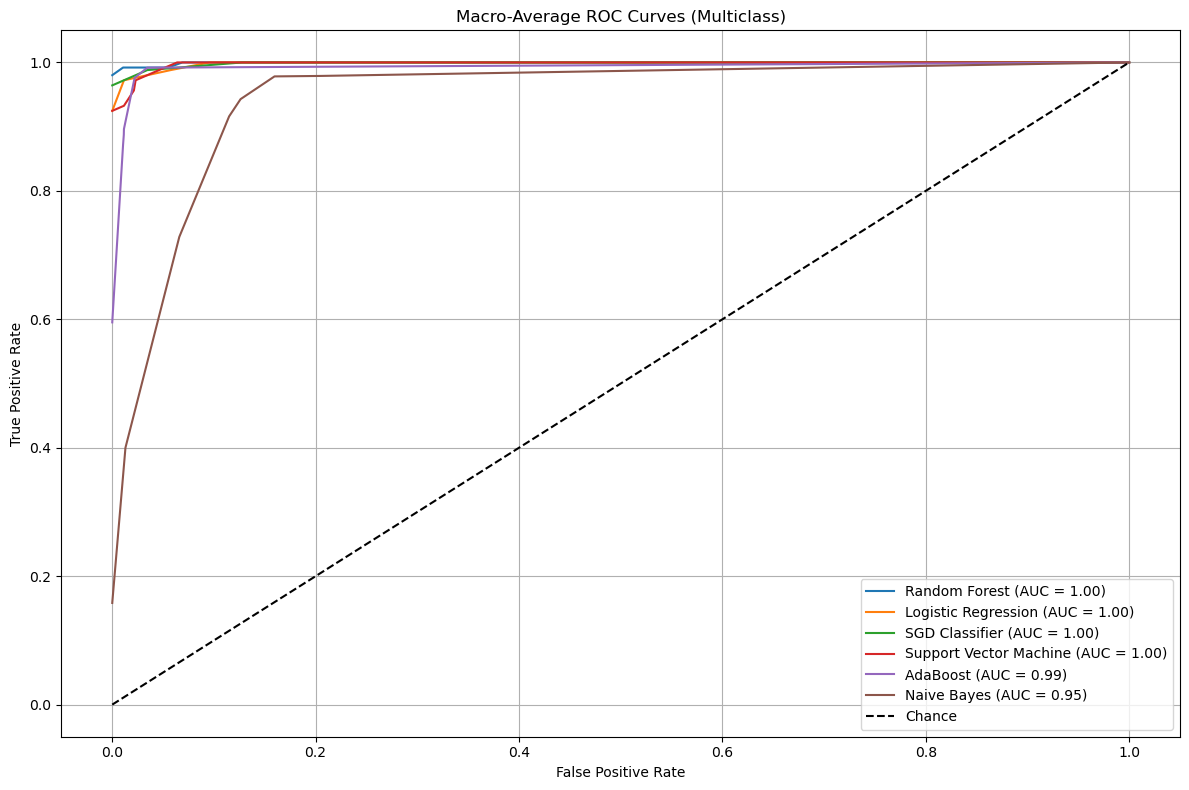

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

# Load dataset
df = pd.read_csv("dermatology_database_1.csv")

# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Convert all columns (except target) to numeric
for col in df.columns[:-1]:
    df[col] = pd.to_numeric(df[col])

# Drop rows with any missing values
df.dropna(inplace=True)

# Separate features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Binarize labels for multiclass ROC
classes = np.unique(y)
y_bin = label_binarize(y, classes=classes)
n_classes = y_bin.shape[1]

# Train-test split
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Classifier list
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SGD Classifier": SGDClassifier(loss='log_loss', random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "AdaBoost": AdaBoostClassifier( random_state=42),
    "Naive Bayes": GaussianNB()
}

# Plot ROC
plt.figure(figsize=(12, 8))

for name, base_model in models.items():
    model = OneVsRestClassifier(base_model)
    model.fit(X_train, y_train_bin)
    
    # Get score
    try:
        y_score = model.predict_proba(X_test)
    except:
        y_score = model.decision_function(X_test)
    
    # ROC and AUC per class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    roc_auc_macro = auc(all_fpr, mean_tpr)

    # Plot ROC
    plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC = {roc_auc_macro:.2f})')

# Chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title("Macro-Average ROC Curves (Multiclass)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
print("imports working")

imports working


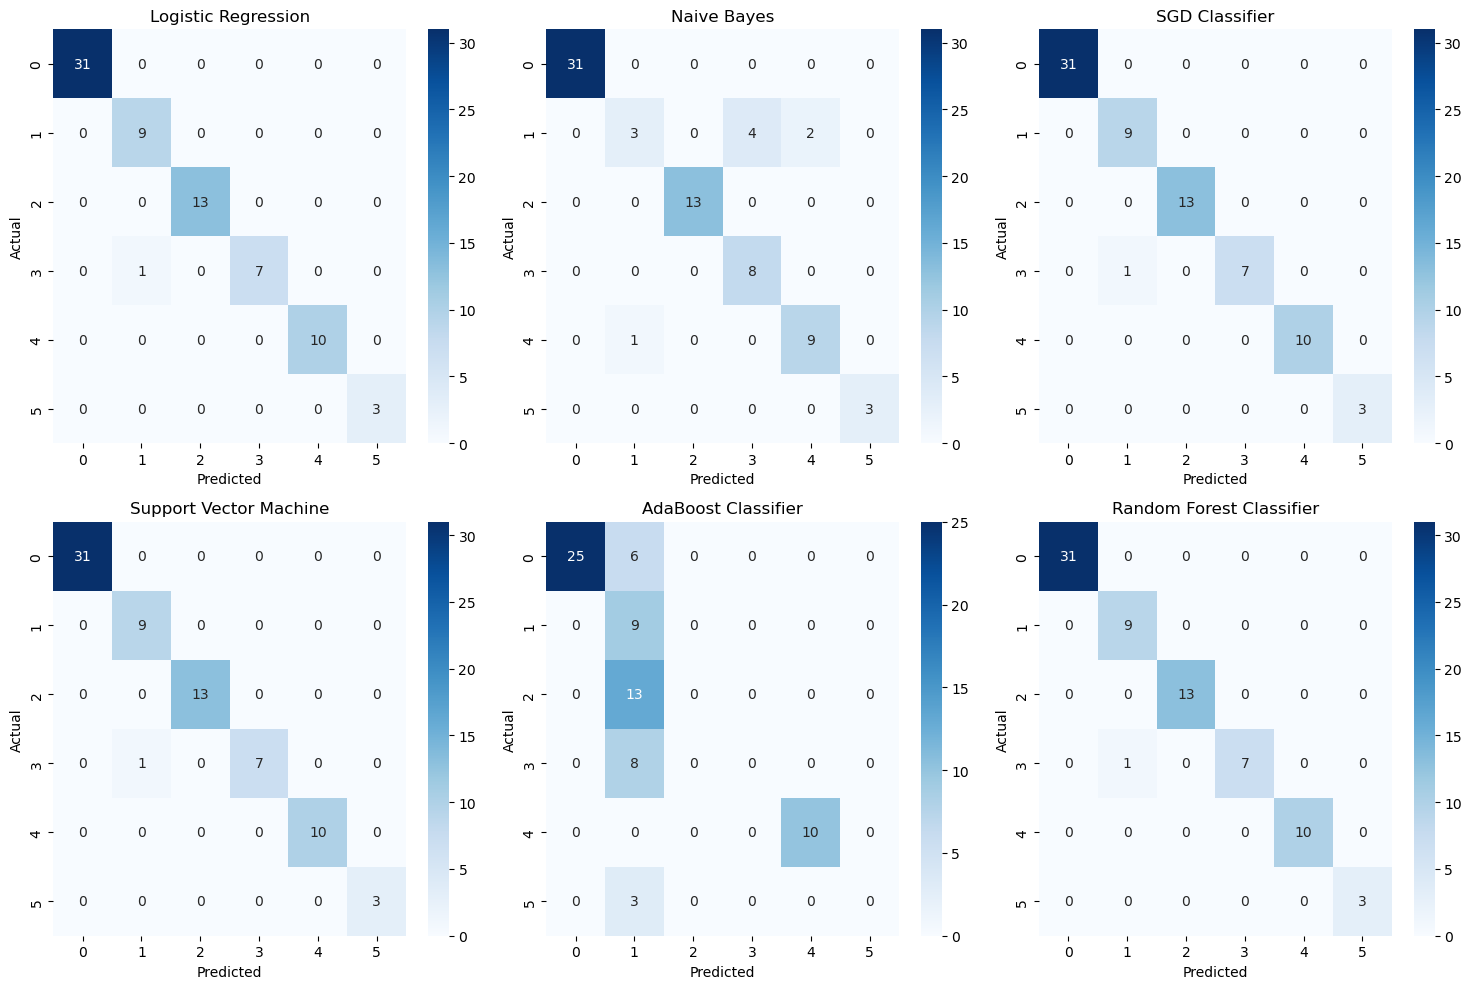

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# List of classifiers
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'SGD Classifier': SGDClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Plotting confusion matrices
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(2, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

Formatted Confusion Matrix:
               Predicted Class 0 Predicted Class 1 Predicted Class 2  \
Actual Class 0           TP0 (1)          FP01 (2)          FP02 (1)   
Actual Class 1          FP10 (4)           TP1 (2)          FP12 (1)   
Actual Class 2          FP20 (1)          FP21 (1)           TP2 (1)   
Actual Class 3          FP30 (6)          FP31 (2)                 0   
Actual Class 4          FP40 (4)          FP41 (2)          FP42 (4)   
Actual Class 5          FP50 (2)                 0          FP52 (3)   

               Predicted Class 3 Predicted Class 4 Predicted Class 5  
Actual Class 0          FP03 (7)          FP04 (4)          FP05 (3)  
Actual Class 1          FP13 (1)          FP14 (3)          FP15 (3)  
Actual Class 2          FP23 (2)          FP24 (2)          FP25 (2)  
Actual Class 3           TP3 (6)          FP34 (4)          FP35 (5)  
Actual Class 4          FP43 (1)           TP4 (6)          FP45 (5)  
Actual Class 5          FP53 (1)         

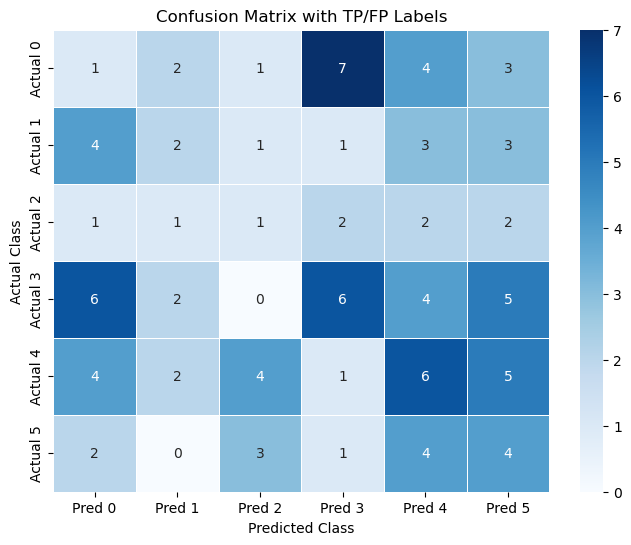

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example: Replace with actual y_test and y_pred from your model
y_test = np.random.randint(0, 6, 100)  # Simulated ground truth labels (0 to 5)
y_pred = np.random.randint(0, 6, 100)  # Simulated predicted labels (0 to 5)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
num_classes = cm.shape[0]

# Initialize TP, FP, FN, TN matrices
TP = np.diag(cm)  # True Positives are the diagonal elements
FP = np.sum(cm, axis=0) - TP  # Column-wise sum minus TP
FN = np.sum(cm, axis=1) - TP  # Row-wise sum minus TP
TN = np.sum(cm) - (TP + FP + FN)  # Everything else

# Create a formatted DataFrame
confusion_df = pd.DataFrame(index=[f"Actual Class {i}" for i in range(num_classes)],
                            columns=[f"Predicted Class {i}" for i in range(num_classes)])

# Fill DataFrame with TP, FP, FN, TN
for i in range(num_classes):
    for j in range(num_classes):
        if i == j:
            confusion_df.iloc[i, j] = f"TP{i} ({TP[i]})"
        else:
            confusion_df.iloc[i, j] = f"FP{i}{j} ({cm[i, j]})" if cm[i, j] > 0 else "0"

# Print formatted confusion matrix
print("Formatted Confusion Matrix:")
print(confusion_df)


# Visualization using Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
            xticklabels=[f"Pred {i}" for i in range(num_classes)],
            yticklabels=[f"Actual {i}" for i in range(num_classes)])
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix with TP/FP Labels")
plt.show()

In [8]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats


# =========================
# 2. LOAD & CLEAN DATA
# =========================
df = pd.read_csv("dermatology_database_1.csv")

# Replace '?' with NaN
df.replace("?", np.nan, inplace=True)

# Convert all columns to numeric
df = df.apply(pd.to_numeric)

# Fill missing values with median
df.fillna(df.median(), inplace=True)


# =========================
# 3. SEPARATE FEATURES & TARGET
# =========================
X = df.drop("class", axis=1)
y = df["class"]


# =========================
# 4. OUTLIER HANDLING (SOFT – SAFE)
# =========================
z_scores = np.abs(stats.zscore(X))
mask = (z_scores < 3).any(axis=1)   # softer filtering

X = X[mask]
y = y[mask]


# =========================
# 5. TRAIN–TEST SPLIT
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# =========================
# 6. FEATURE SCALING
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# =========================
# 7. FEATURE SELECTION (RFE + LINEAR SVM)
# =========================
rfe = RFE(
    estimator=LinearSVC(max_iter=6000),
    n_features_to_select=8
)

X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

selected_features = X.columns[rfe.support_]
print("\nSelected Important Features:")
print(list(selected_features))


# =========================
# 8. MODELS
# =========================
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SGD Classifier": SGDClassifier(random_state=42),
    "Support Vector Machine": SVC(),
    "AdaBoost": AdaBoostClassifier(),

}


# =========================
# 9. TRAIN, TEST & METRICS
# =========================
results = []

for name, model in models.items():
    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)

    results.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(
            y_test, y_pred, average="weighted", zero_division=0), 4),
        "Recall": round(recall_score(
            y_test, y_pred, average="weighted", zero_division=0), 4),
        "F1-score": round(f1_score(
            y_test, y_pred, average="weighted", zero_division=0), 4)
    })


# =========================
# 10. FINAL RESULTS TABLE
# =========================
results_df = pd.DataFrame(results)

print("\nFINAL RESULTS TABLE (After Feature Selection):\n")
print(results_df)



Selected Important Features:
['koebner_phenomenon', 'polygonal_papules', 'oral_mucosal_involvement', 'knee_and_elbow_involvement', 'fibrosis_papillary_dermis', 'clubbing_rete_ridges', 'thinning_suprapapillary_epidermis', 'disappearance_granular_layer']

FINAL RESULTS TABLE (After Feature Selection):

                    Model  Accuracy  Precision  Recall  F1-score
0           Random Forest    0.9730     0.9779  0.9730    0.9737
1     Logistic Regression    0.9730     0.9779  0.9730    0.9737
2          SGD Classifier    0.9865     0.9899  0.9865    0.9871
3  Support Vector Machine    0.9730     0.9779  0.9730    0.9737
4                AdaBoost    0.8108     0.7795  0.8108    0.7788
